In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress Deprecation and Incorrect Usage Warnings
import warnings
warnings.filterwarnings('ignore')

# Expand cell and pandas width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

In [18]:
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
print(train.shape)
train.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [19]:
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
print(test.shape)
test.head(3)

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


casual, registered, count 가 test에는 없다. count는 예측해야할 값이고, casual + registered 가 count 인것을 알 수 있다.

# Feature Engineering

In [4]:
def split_date(dt):
    dt['year'] = dt['datetime'].dt.year
    dt['month'] = dt['datetime'].dt.month
    dt['day'] = dt['datetime'].dt.day
    dt['hour'] = dt['datetime'].dt.hour
    dt['minute'] = dt['datetime'].dt.minute
    dt['second'] = dt['datetime'].dt.second
    dt['dayofweek'] = dt['datetime'].dt.dayofweek
    
    return dt

In [20]:
train = split_date(train)
print(train.shape)
train.head(3)

(10886, 19)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5


In [21]:
test = split_date(test)
print(test.shape)
test.head(3)  

(6493, 16)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3


### 풍속이 0인 값들이 많다. => 정상적인 측정값이 아니라 생각이 되므로 고쳐줘야함

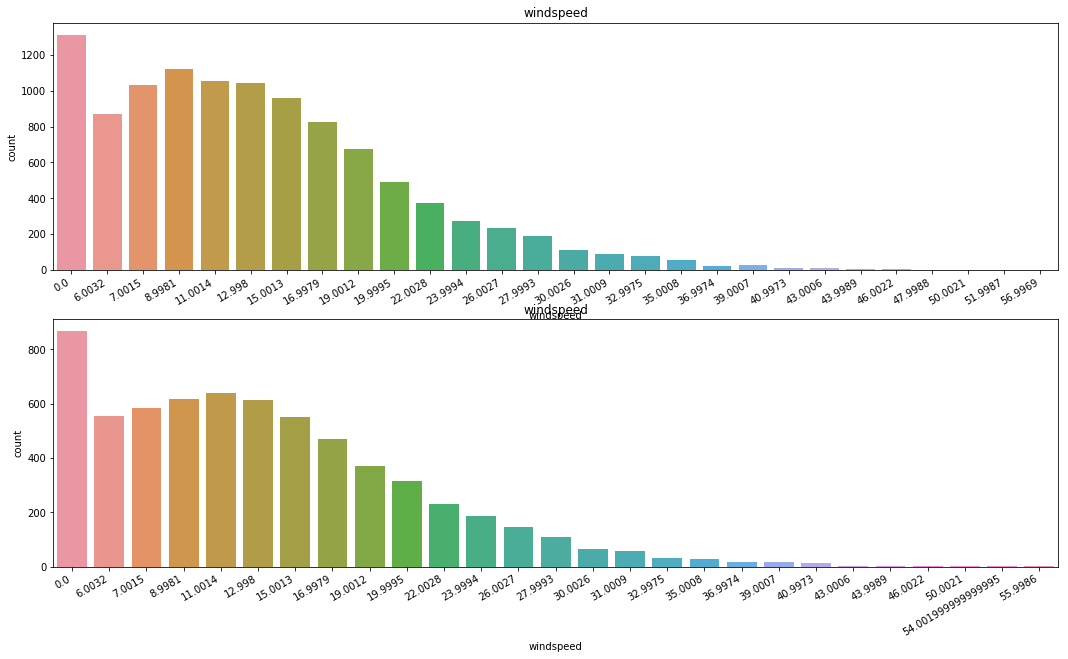

In [22]:
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18, 10)

def windspeed_graph(ax, data):
    plt.sca(ax)
    plt.xticks(rotation=30, ha='right')
    ax.set(ylabel='Count', title='windspeed')
    sns.countplot(data=data, x='windspeed', ax=ax)
    
windspeed_graph(axes[0], train)
windspeed_graph(axes[1], test)

### 풍속이 0인 것과 아닌것을 나누어 0을 예측한 값으로 채운다.

- train : 풍속이 0이 아닌 데이터

그 학습관 결과를 가지고 풍속이 0인 값들을 예측치로 채우도록 하겠다.

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
def predict_windspeed(data):
    
    data_wind_0 = data.loc[data['windspeed'] == 0]
    data_wind_not0 = data.loc[data['windspeed'] != 0]
    
    print(data_wind_0.shape)
    print(data_wind_not0.shape)
    
    wind_features = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
    
    data_wind_not0['windspeed'] = data_wind_not0['windspeed'].astype('str')
    
    rfc = RandomForestClassifier()
    
    # 학습
    rfc.fit(data_wind_not0[wind_features], data_wind_not0['windspeed'])
    
    # 예측
    wind_0_values = rfc.predict(X=data_wind_0[wind_features])
    
    predict_wind_0 = data_wind_0
    predict_wind_not0 = data_wind_not0
    
    predict_wind_0['windspeed'] = wind_0_values
    
    data = predict_wind_not0.append(predict_wind_0)
    
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

(1313, 19)
(9573, 19)


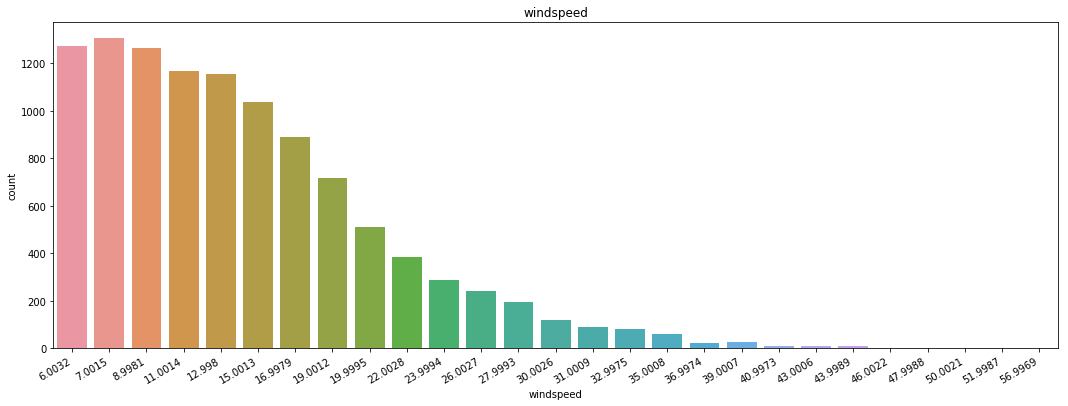

In [24]:
train = predict_windspeed(train)

fig, ax1 = plt.subplots()
fig.set_size_inches(18, 6)

windspeed_graph(ax1, train)

# Feature Selection

- 신호와 잡음을 구분해야 한다.
- feature가 많다고 무조건 좋은 성능을 내지 않는다.
- feature를 하나씩 추가하고 변경해 가면서 성능에 안좋은건 제거해야 한다.
- 그리고 숫자로서 크다/작다/더해서 다른 것이 된다 등의 관계와 상관없고 단순히 구분으로서의 의미만 있는 것들은 `type`을 `category`로 변경해야 한다.

In [25]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek'],
      dtype='object')

In [26]:
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for col in categorical_feature_names:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [27]:
features = ['temp', 'atemp', 'humidity', 'windspeed'] + categorical_feature_names
features

['temp',
 'atemp',
 'humidity',
 'windspeed',
 'season',
 'holiday',
 'workingday',
 'weather',
 'dayofweek',
 'month',
 'year',
 'hour']

In [30]:
X_train = train[features]
X_test = test[features]
label_name = 'count'
y_train = train[label_name]

# RMSLE

In [31]:
from sklearn.metrics import make_scorer

In [32]:
def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)

    # 평균을 낸다.
    mean_difference = difference.mean()

    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# Cross Validation (KFold)

In [33]:
from sklearn.model_selection import KFold, cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# RandomForest

In [34]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [35]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print('Score= {0:.5f}'.format(score))

CPU times: user 37.5 s, sys: 1.08 s, total: 38.6 s
Wall time: 7.57 s
Score= 0.32269


# Train

In [36]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(predictions.shape)
predictions[:10]

(6493,)


array([ 11.5 ,   5.33,   4.05,   3.24,   3.01,   5.59,  35.89,  87.12,
       198.12, 118.8 ])

# train, test 의 score를 시각화

[Text(0.5,1,'test')]

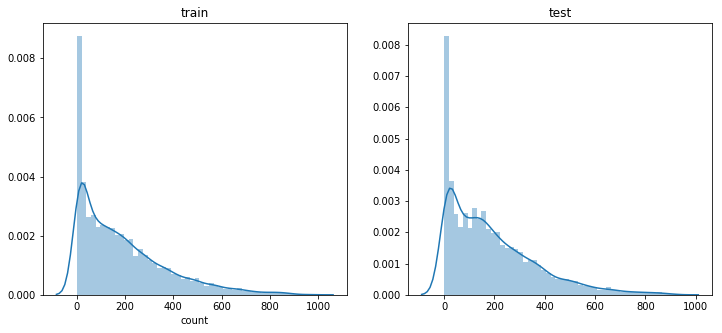

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

# Submit

In [39]:
submission = pd.read_csv('data/sampleSubmission.csv')
submission.head(3)

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0


In [40]:
submission['count'] = predictions
submission.head(3)

,datetime,count
0,2011-01-20 00:00:00,11.50
1,2011-01-20 01:00:00,5.33
2,2011-01-20 02:00:00,4.05


In [41]:
submission.to_csv('data/Score_{0:.5f}_submission.csv'.format(score), index=False)

- Score : 0.46907
- Rank : 1084

In [42]:
features = ['temp', 'humidity', 'windspeed', 'season', 'workingday', 'weather', 'month', 'year', 'hour']

In [43]:
X_train = train[features]
X_test = test[features]
y_train = train[label_name]

In [44]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print('Score= {0:.5f}'.format(score))

CPU times: user 29.2 s, sys: 1.02 s, total: 30.2 s
Wall time: 6.22 s
Score= 0.34953


In [45]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(predictions.shape)
predictions[:10]

(6493,)


array([  8.21 ,   4.74 ,   5.67 ,   3.265,   2.98 ,   5.97 ,  36.87 ,
        89.11 , 189.63 , 109.48 ])

[Text(0.5,1,'test')]

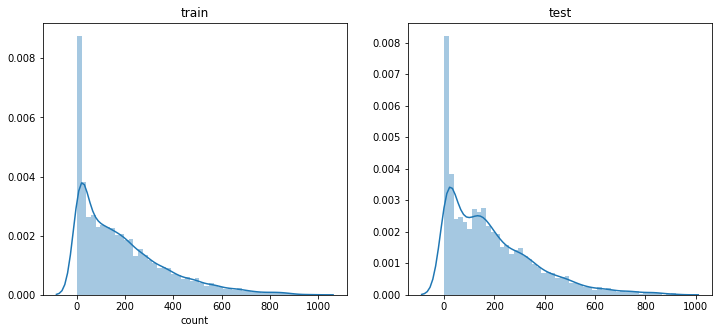

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

In [47]:
submission['count'] = predictions
submission.to_csv('data/Score_{0:.5f}_submission.csv'.format(score), index=False)

- Score: 0.48347

In [48]:
features = ['temp', 'humidity', 'windspeed', 'season','holiday', 'workingday', 'weather', 'month', 'year', 'hour']

CPU times: user 30.2 s, sys: 1.09 s, total: 31.3 s
Wall time: 6.76 s
Score= 0.34335
(6493,)


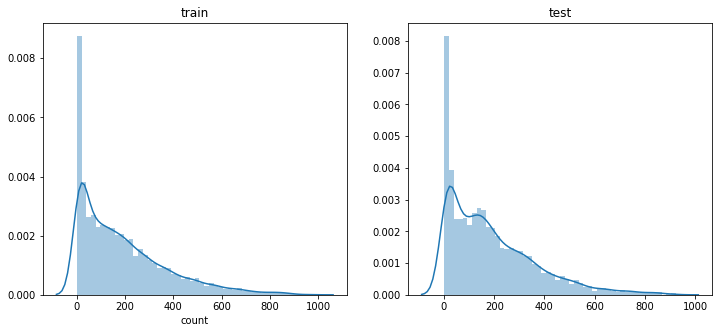

In [49]:
X_train = train[features]
X_test = test[features]
y_train = train[label_name]

%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print('Score= {0:.5f}'.format(score))

model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(predictions.shape)
predictions[:10]

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12, 5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

submission['count'] = predictions
submission.to_csv('data/Score_{0:.5f}_submission.csv'.format(score), index=False)

In [53]:
features = ['temp', 'humidity', 'windspeed', 'season','holiday', 'workingday', 'weather', 'month', 'year', 'workingday', 'hour']

In [55]:
def make_submission(features):
    X_train = train[features]
    X_test = test[features]
    y_train = train[label_name]

    score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
    score = score.mean()
    print('Score= {0:.5f}'.format(score))

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    print(predictions.shape)
    predictions[:10]

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(12, 5)

    sns.distplot(y_train, ax=ax1, bins=50)
    ax1.set(title='train')

    sns.distplot(predictions, ax=ax2, bins=50)
    ax2.set(title='test')

    submission['count'] = predictions
    submission.to_csv('data/Score_{0:.5f}_submission.csv'.format(score), index=False)
    

Score= 0.34261
(6493,)


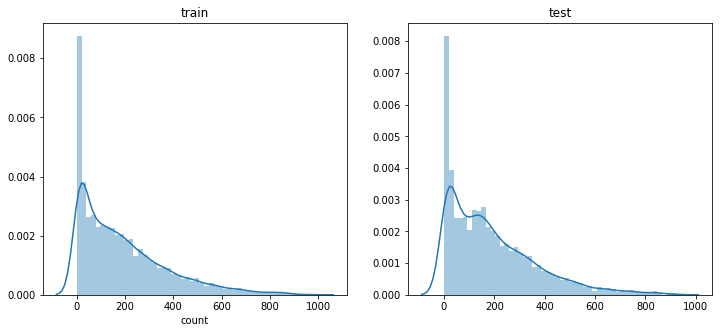

In [56]:
make_submission(features)

In [59]:
features = ['temp', 'atemp', 'humidity', 'windspeed', 'season','holiday', 'workingday', 'weather', 'month', 'year', 'dayofweek', 'hour']

Score= 0.32288
(6493,)


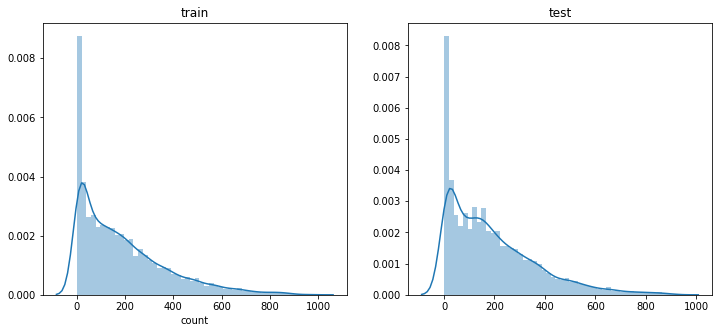

In [60]:
make_submission(features)

- Score : 0.46887
- Rank : 1080